# DRIVE SAFE IN GENEVA


## Table of Contents

<p>
<div class="lev1"><a href='#1Understand_data'><span class="toc-item-num">1.&nbsp;&nbsp;</span>Understand the data</a></div> 
<div class="lev1"><a href='#31Libraries'><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Libraries import and dataset load</a></div>
<div class="lev1"><a href='#32Feature'><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Feature subgroup exploration</a></div>
<div class="lev1"><a href='#321Time'><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Time</a></div>
<div class="lev1"><a href='#322Localisation'><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Localisation</a></div>
<div class="lev1"><a href='#323Conditions'><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Conditions</a></div>
<div class="lev1"><a href='#324Accident'><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Accident type</a></div>
</p>

# 1. Load dataset

First of all, some useful libraries will be imported and the dataset will be loaded. Then the dataset shape and the data type of each feature will be inspectioned:

In [1]:
# Import used libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import folium

from pyproj import Proj, transform

from datetime import datetime
from datetime import date, time
from dateutil.parser import parse

import pickle

In [2]:
# Load dataset
acc_data = '../_data/OTC_ACCIDENTS.csv'
compt_trafic_data = '../_data/OTC_COMPTAGE_TRAFIC.csv'
acc_df = pd.read_csv(acc_data, sep=';', encoding='latin-1')
compt_trafic_df = pd.read_csv(compt_trafic_data, sep=';', encoding='latin-1')

# Show the dataset
acc_df.head(3)

,ID_ACCIDENT,DATE_,GROUPE_ACCIDENT,CAUSE,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,...,NB_MOTOS_50,NB_MOTOS_125,NB_MOTOS_11KW,NB_VOITURES_TOURISME,NB_VOITURES_LIVRAISON,NB_CAMIONS,NB_BUS,NB_TRAM,E,N
0,876245.0,2010-11-30 00:00:00,Dérapage ou perte de maîtrise,Inattention et distraction - Manque d'attentio...,Genève,Nuit,Chute de neige,Avec blessés légers,2500774.0,1117364.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2500774.0,1117364.0
1,879408.0,2010-12-08 00:00:00,Autres,Utilisation inadéquate du véhicule - Stationne...,Genève,Jour,Beau,Autres,2498974.0,1118100.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2498974.0,1118100.0
2,877254.0,2010-12-02 00:00:00,Dérapage ou perte de maîtrise,Inobservation de signaux ou de la signalisatio...,Vandoeuvres,Jour,Couvert,Avec blessés légers,2504618.0,1119635.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2504618.0,1119635.0


In [3]:
# Shape of the dataset
acc_df.shape

(19231, 35)

In [4]:
# Information of the dataset (feature name, size, dtype)
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19231 entries, 0 to 19230
Data columns (total 35 columns):
ID_ACCIDENT              19231 non-null float64
DATE_                    19231 non-null object
GROUPE_ACCIDENT          19231 non-null object
CAUSE                    19231 non-null object
COMMUNE                  19231 non-null object
CONDITIONS_LUMINEUSES    19231 non-null object
CONDITIONS_METEO         19231 non-null object
CONSEQUENCES             19231 non-null object
COOR_X                   19231 non-null float64
COOR_Y                   19231 non-null float64
ETAT_ROUTE               19231 non-null object
GENRE_ROUTE              19231 non-null object
HEURE                    19230 non-null object
JOUR                     19231 non-null object
LOCALITE                 19231 non-null object
NB_ENFANTS_IMPLIQUES     19231 non-null float64
NB_ENFANTS_ECOLE         19231 non-null float64
NB_BLESSES_LEGERS        19231 non-null float64
NB_BLESSES_GRAVES        19231 non-null

In [5]:
# Delete unuseful feature
del acc_df['ID_ACCIDENT']

The Geneva accidents dataset has **19'231 datapoints** with **35 different features**.

# 2. Understand the data
<a id='1Understand_data'></a>

The goal of this section is:
- Understand the data (formats, distributions, missing values and correlations)
- Feature engineering: Enrich our dataset with new features, tranform the data to have a deeper analysis

The different features can be grouped in the following subgroups:

1. **Time**: DATE_, HEURE, JOUR

2. **Localisation**: COMMUNE, COOR_X, COOR_Y, LOCALITE, E, N 

3. **Conditions**: CONDITIONS_LUMINEUSES, CONDITIONS_METEO, ETAT_ROUTE, GENRE_ROUTE

4. **Accident type**: GROUPE_ACCIDENT, CAUSE

5. **Accident seriousness**: CONSEQUENCE, NB_BLESSES_LEGERS, NB_BLESSES_GRAVES, NB_TUES, NB_ENFANTS_IMPLIQUES, NB_ENFANTS_ECOLE, NB_PIETONS 

6. **Vehicles involved**: NB_BICYCLETTES, NB_VAE_25, NB_VAE_45, NB_CYCLOMOTEURS, NB_MOTOS_50, NB_MOTOS_125, NB_MOTOS_11KW, NB_VOITURES_TOURISME, NB_VOITURES_LIVRAISON, NB_CAMIONS, NB_BUS, NB_TRAM

First of all, some plot helpers functions will be created:

In [6]:
# Plot helper functions
def value_barplot_label(plot_name):
    # Inserts the value label on the top of each bar.

    for p in plot_name.patches:
        height = p.get_height()
        plot_name.text(p.get_x()+p.get_width()/2., height,'{:0.0f}'.format(height), ha="center").set_weight('bold')

def tick_format(plot,tick_type):
    if tick_type == 1:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
            label.set_rotation(90) 
        for label in plot.get_yticklabels():
            label.set_fontsize(14)
    
    if tick_type == 2:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
        for label in plot.get_yticklabels():
            label.set_fontsize(14)
    
    if tick_type == 3:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
        for label in plot.get_yticklabels():
            label.set_fontsize(14)
            label.set_rotation(20)

Let's investigate each of this subgroups separetly:

## 2.1 Time
<a id='321Time'></a>

An important feature of the accidents datasets is the time: It answers the question **WHEN** the accidents happen. This feature will be very useful for our further analysis. In this group there are:
- Date
- Hour
- Day of the week

Let's check the format of this three features:

In [7]:
print(acc_df.DATE_.head(1))
print(acc_df.HEURE.head(1))
print(acc_df.JOUR.head(1))

0    2010-11-30 00:00:00
Name: DATE_, dtype: object
0    1899-12-30 21:00:00
Name: HEURE, dtype: object
0    Mardi
Name: JOUR, dtype: object


In order to use these features, we need to change to time format. In addition, `Year`, `Month` and `Day` features will be created to enrich our dataset:

In [8]:
# Datetime format
acc_df['DATE_'] = acc_df['DATE_'].apply(lambda d: pd.to_datetime(d))
acc_df['HEURE'] = acc_df['HEURE'].apply(lambda d: pd.to_datetime(d))

# Create new time features
acc_df['YEAR'] = [date.year for date in acc_df['DATE_']]
acc_df['MONTH'] = [date.month for date in acc_df['DATE_']]
acc_df['DAY'] = [date.day for date in acc_df['DATE_']]
acc_df['HEURE'] = acc_df['HEURE'].apply(lambda d: pd.to_datetime(d))
acc_df['HEURE'] = acc_df['HEURE'].fillna(acc_df['HEURE'].iloc[0])  # Fillna with first value of the df (Error neglible)
acc_df['HOUR'] = [date.hour for date in acc_df['HEURE']]
acc_df.drop('HEURE', axis=1, inplace=True)

# Verify that the format is as wished
print(acc_df.DATE_.head(1))
print(acc_df.YEAR.head(1))
print(acc_df.MONTH.head(1))
print(acc_df.DAY.head(1))
print(acc_df.HOUR.head(1))


0   2010-11-30
Name: DATE_, dtype: datetime64[ns]
0    2010
Name: YEAR, dtype: int64
0    11
Name: MONTH, dtype: int64
0    30
Name: DAY, dtype: int64
0    21
Name: HOUR, dtype: int64


Once the time data can be treated, we start our exploratory analysis by computing:
- Number of accidents per year
- Number of accidents per month
- Number of accidents per day of the month
- Number of accidents per weekday

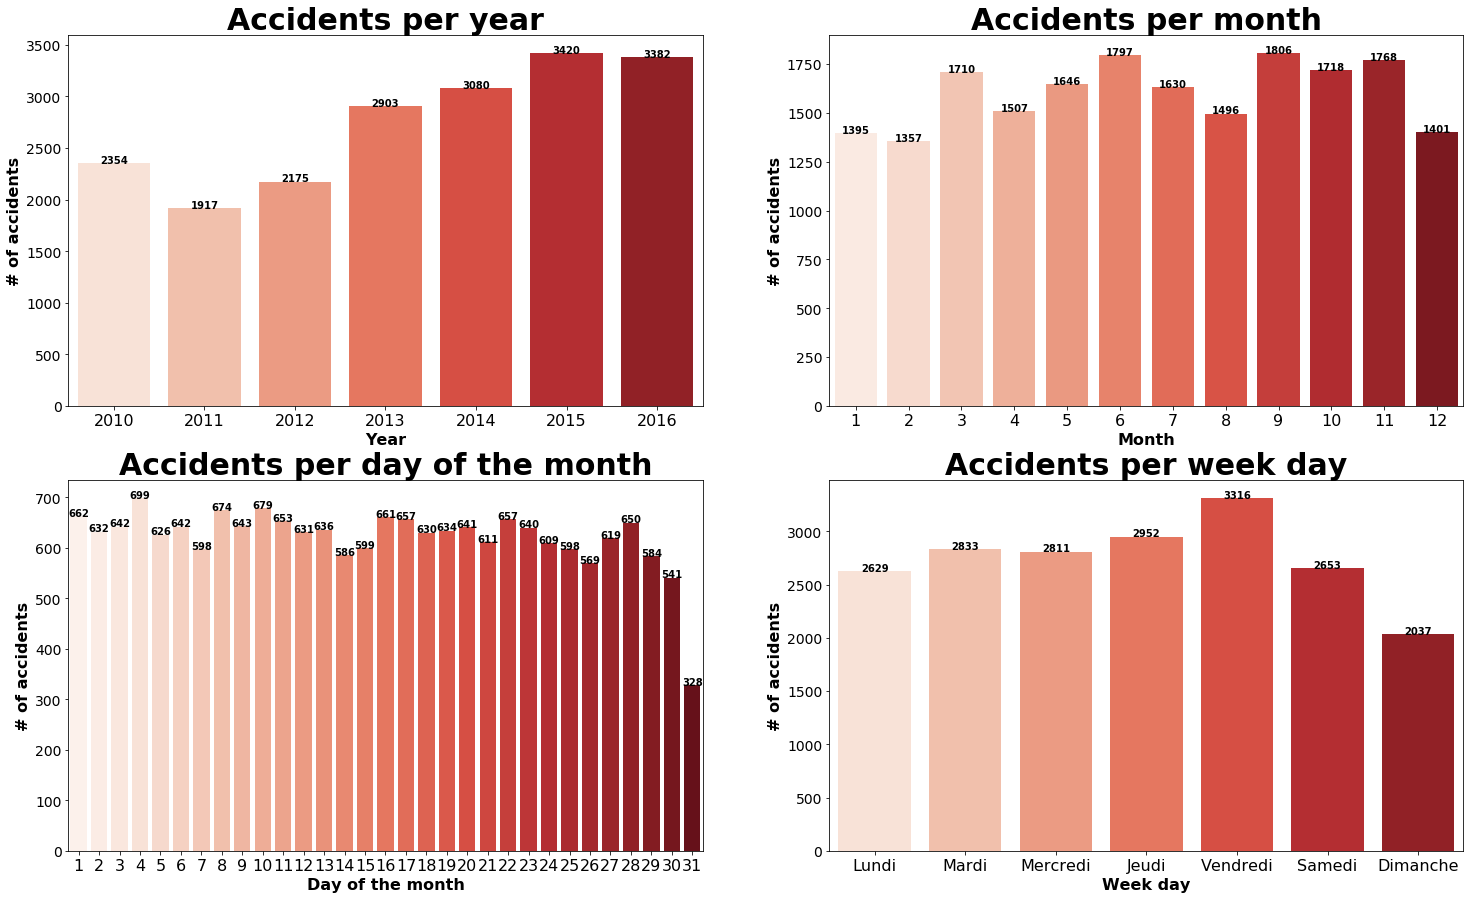

In [9]:
fig = plt.figure(figsize=(25,15))

# Visualize accidents per Year
ax1 = fig.add_subplot(221)
acc_per_year = acc_df.YEAR.value_counts(ascending=True, sort=False)
ax1 = sns.barplot(x=acc_per_year.index, 
                 y=acc_per_year, 
                 palette='Reds',
                 ax=ax1)
value_barplot_label(ax1)
plt.title("Accidents per year", fontsize=30).set_weight('bold')
tick_format(ax1, 2)
ax1.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax1.set_xlabel('Year', fontsize=16).set_weight('bold')

# Visualize accidents per month
ax2 = fig.add_subplot(222)
acc_per_month = acc_df.MONTH.value_counts(ascending=True, sort=False)
ax2 = sns.barplot(x=acc_per_month.index, 
                 y=acc_per_month, 
                 palette='Reds',
                 ax=ax2)
value_barplot_label(ax2)
plt.title("Accidents per month", fontsize=30).set_weight('bold')
tick_format(ax2, 2)
ax2.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax2.set_xlabel('Month', fontsize=16).set_weight('bold')

# Visualize accidents per day of the month
ax3 = fig.add_subplot(223)
acc_per_day = acc_df.DAY.value_counts(ascending=True, sort=False)
ax3 = sns.barplot(x=acc_per_day.index, 
                 y=acc_per_day, 
                 palette='Reds',
                 ax=ax3)
value_barplot_label(ax3)
plt.title("Accidents per day of the month", fontsize=30).set_weight('bold')
tick_format(ax3, 2)
ax3.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax3.set_xlabel('Day of the month', fontsize=16).set_weight('bold')

# Visualize accidents per weekday
ax4 = fig.add_subplot(224)
weekdays=['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
acc_per_weekday = acc_df.JOUR.value_counts(ascending=True, sort=False).reindex(weekdays)
ax4 = sns.barplot(x=acc_per_weekday.index, 
                 y=acc_per_weekday, 
                 palette='Reds',
                 ax=ax4)
value_barplot_label(ax4)
plt.title("Accidents per week day", fontsize=30).set_weight('bold')
tick_format(ax4, 2)
ax4.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax4.set_xlabel('Week day', fontsize=16).set_weight('bold')

From the plots above we can draw some first observations of the time features:
- There is an observable **increase of number of accidents** between 2011 to 2015. In 2016, there is a neglegible decrease.
- During the year, it can be observed some up-downs. There is a **peak of accidents** in March, June, September, October and November. Our first guess is that during the months when holidays start or end, it is more probable to have an accident. A further analysis could be done in order to verify the first assumption by getting the information of the year holidays and seeing the correlation with the accidents dates. 
- During the differents months of the year, there is no appreciable correlation within the month and the probability to have an accident.
- However, during the week, the days with higher probability to have an accident are Thurstday and Friday. 

From this last conslusion, the evolution during the years of the days of the week with higher probability to have an accident will be investigated:

In [10]:
# Compute number of accidents per day of the week and per year
weekdays=['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
years = np.arange(2010,2017,1)
per_weekday_per_year_df = pd.DataFrame()
for y in years:
    string = str(y)
    per_weekday_per_year_df[string] = acc_df[acc_df['YEAR']==y].JOUR.value_counts(ascending=True, sort=False).reindex(weekdays)
per_weekday_per_year_df

,2010,2011,2012,2013,2014,2015,2016
Lundi,303,261,313,424,422,462,444
Mardi,346,272,328,442,488,483,474
Mercredi,356,293,312,427,452,492,479
Jeudi,361,308,317,450,456,493,567
Vendredi,424,330,348,453,530,619,612
Samedi,309,240,332,394,428,478,472
Dimanche,255,213,225,313,304,393,334


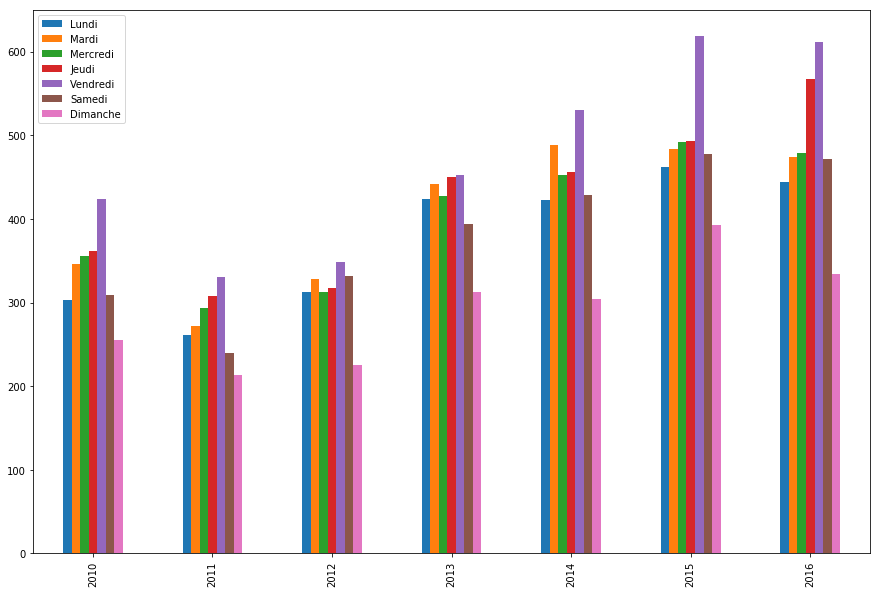

In [11]:
# Visualize the evolution
per_weekday_per_year_df=per_weekday_per_year_df.transpose()
per_weekday_per_year_df.plot.bar(figsize=(15,10))

From the plot above we can draw that during the years, there is an **relative increase** of the proportion of **accidents on Friday**.

In order to get more time information and help to drow better conclusions, the `DayTime` and `SEASON` will be created.

The `DayTime` feature is defined from the feature `HOUR` as follows:
- From 22 to 6: **Night**
- From 6 to 11: **Morning**
- From 11 to 13: **Mid-day**
- From 13 to 17: **Afternoon**
- From 17 to 22: **Evening**

The `SEASON` feature is defined from the feature `MONTH` as follows:
- From December to March: **Winter**
- From April to June: **Spring**
- From July to August: **Summer**
- From September to November: **Autumn**

It is importe to note that this classes are unbalanced. However, represent better the real world as can define the kind of travels of people that have an accident.

In [12]:
# Bin by daytime
bins = (-0.1, 5, 10, 13, 17, 22, 24.1)
daytime_names = ['Night', 'Morning', 'Mid-day', 'Afternoon','Evening', 'Night']
daytime = pd.cut(acc_df.HOUR, bins, labels=daytime_names)
acc_df['DayTime'] = daytime

In [13]:
# Bin by season
bins = (0, 3, 6, 8, 11, 12.1)
season_names = ['Winter', 'Spring', 'Summer', 'Autumn', 'Winter']
season = pd.cut(acc_df.MONTH, bins, labels=season_names)
acc_df['SEASON'] = season

Let's visualize the accident dataset with the time features:

In [14]:
# Visualize the time features
time_features = ['DATE_','YEAR', 'MONTH', 'DAY','JOUR', 'HOUR', 'DayTime', 'SEASON']
acc_df[time_features].head(3)

,DATE_,YEAR,MONTH,DAY,JOUR,HOUR,DayTime,SEASON
0,2010-11-30,2010,11,30,Mardi,21,Evening,Autumn
1,2010-12-08,2010,12,8,Mercredi,14,Afternoon,Winter
2,2010-12-02,2010,12,2,Jeudi,10,Morning,Winter


## 2.2 Localisation
<a id='322Localisation'></a>

An other important question to ask is **WHERE** the accidents happen. 
 
As localisation features, it can be found:
- `COOR_X`: X coordenate in 'epsg_2056' reference system
- `COOR_Y`: X coordenate in 'epsg_2056' reference system
- `E`,`N`: Gives the same informationa as COOR_X and COOR_Y
- `COMMUNE`: The commune where the accident have happened
- `LOCALITE `: Gives the information if the accident happened on the outskirts of the locaity or inside.

COOR_X and COOR_Y coordenates will be projected in the GPS coordenates, also called 'epsg:4326' reference system. For this, the Proj and transform libraries will be used:

In [15]:
# projection definition
p1 = Proj(init='epsg:2056')
p2 = Proj(init='epsg:4326')

# Helper functions
def coord_proj(acc_df,i, p1, p2):
    x1 = acc_df['COOR_X'].loc[i]
    y1 = acc_df['COOR_Y'].loc[i]
    x2, y2 = transform(p1,p2,x1,y1)
    acc_df['COOR_X'].set_value(i, x2)
    acc_df['COOR_Y'].set_value(i, y2)
    return acc_df

# Project data
for i in range(0, len(acc_df['COOR_X'])-1):
    acc_df = coord_proj(acc_df,i, p1, p2)

    # Delete unuseful columns
del acc_df['N']
del acc_df['E']
acc_df.head(3)

,DATE_,GROUPE_ACCIDENT,CAUSE,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,ETAT_ROUTE,...,NB_VOITURES_LIVRAISON,NB_CAMIONS,NB_BUS,NB_TRAM,YEAR,MONTH,DAY,HOUR,DayTime,SEASON
0,2010-11-30,Dérapage ou perte de maîtrise,Inattention et distraction - Manque d'attentio...,Genève,Nuit,Chute de neige,Avec blessés légers,6.153116,46.200401,Enneigée,...,0.0,0.0,0.0,0.0,2010,11,30,21,Evening,Autumn
1,2010-12-08,Autres,Utilisation inadéquate du véhicule - Stationne...,Genève,Jour,Beau,Autres,6.129641,46.206753,Sèche,...,0.0,0.0,0.0,0.0,2010,12,8,14,Afternoon,Winter
2,2010-12-02,Dérapage ou perte de maîtrise,Inobservation de signaux ou de la signalisatio...,Vandoeuvres,Jour,Couvert,Avec blessés légers,6.202445,46.221384,Enneigée,...,0.0,0.0,0.0,0.0,2010,12,2,10,Morning,Winter


An other localisation feature is the `COMMUNE`. In order more information to get insight of the accidents dataset, it will be interesting to have the number of inhabitants of each Commune (**To Develop**)

Let's understand in which Commune the accidents happen.

In [16]:
# Visualize the number of accidents per commune
acc_df.COMMUNE.value_counts()

Genève               8913
Vernier              1486
Petit-Lancy          1054
Meyrin                971
Carouge GE            858
Plan-les-Ouates       501
Le Grand-Saconnex     491
Thônex                435
Conches               412
Versoix               404
Bernex                367
Cologny               345
Bellevue              321
Onex                  315
Chêne-Bourg           273
Vésenaz               266
Vessy                 200
Confignon             167
Perly                 149
Satigny               145
Chambésy              113
Vandoeuvres           111
Genthod                83
Jussy                  80
Meinier                76
La Croix-de-Rozon      74
Corsier GE             66
Anières                61
Puplinge               52
Collex                 51
Troinex                50
Choulex                37
Avully                 35
La Plaine              32
Cartigny               30
Russin                 29
Chancy                 29
Aire-la-Ville          28
Soral       

In [17]:
# Localité
acc_df.LOCALITE.value_counts()

A l'intérieur d'une localité    10789
Non renseigné                    6101
A l'extérieur d'une localité     2341
Name: LOCALITE, dtype: int64

## 2.3 Conditions
<a id='323Conditions'></a>

This section investigates the question **HOW**. The external conditions of each accident will be analysed. 

In the list of external conditions we can find:
- Light conditions (`CONDITIONS_LUMINEUSES`)
- Weather conditions (`CONDITIONS_METEO`)
- Road conditions (`ETAT_ROUTE`)
- Road type (`GENRE_ROUTE`)


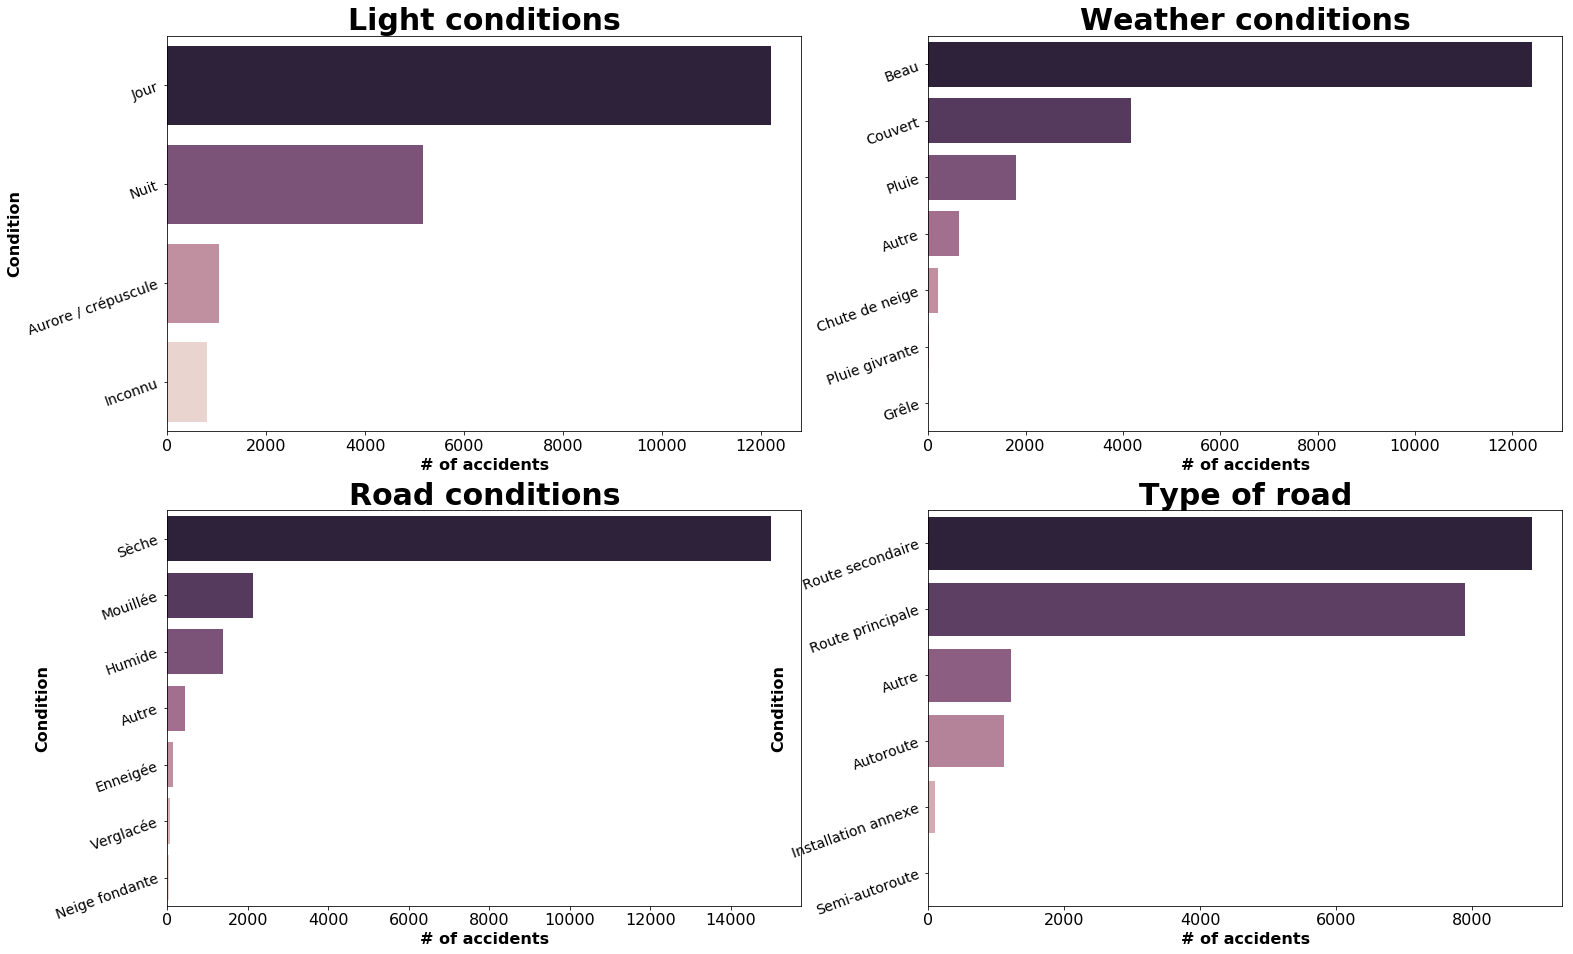

In [18]:
fig = plt.figure(figsize=(25,16))

# Visualize the accident group
ax1 = fig.add_subplot(221)
light_cond = acc_df.CONDITIONS_LUMINEUSES.value_counts()
ax1 = sns.barplot(x=light_cond, 
                 y=light_cond.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(light_cond.index)),
                 ax=ax1)
plt.title("Light conditions", fontsize=30).set_weight('bold')
tick_format(ax1, 3)
ax1.set_ylabel('Condition', fontsize=16).set_weight('bold')
ax1.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

# Visualize the accident group
ax2 = fig.add_subplot(222)
weather_cond = acc_df.CONDITIONS_METEO.value_counts()
ax2 = sns.barplot(x=weather_cond, 
                 y=weather_cond.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(weather_cond.index)),
                 ax=ax2)
plt.title("Weather conditions", fontsize=30).set_weight('bold')
tick_format(ax2, 3)
ax2.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

# Visualize the accident group
ax3 = fig.add_subplot(223)
road_cond = acc_df.ETAT_ROUTE.value_counts()
ax3 = sns.barplot(x=road_cond, 
                 y=road_cond.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(road_cond.index)),
                 ax=ax3)
plt.title("Road conditions", fontsize=30).set_weight('bold')
tick_format(ax3, 3)
ax3.set_ylabel('Condition', fontsize=16).set_weight('bold')
ax3.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

# Visualize the accident group
ax4 = fig.add_subplot(224)
road_type = acc_df.GENRE_ROUTE.value_counts()
ax4 = sns.barplot(x=road_type, 
                 y=road_type.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(road_type.index)),
                 ax=ax4)
plt.title("Type of road", fontsize=30).set_weight('bold')
tick_format(ax4, 3)
ax4.set_ylabel('Condition', fontsize=16).set_weight('bold')
ax4.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


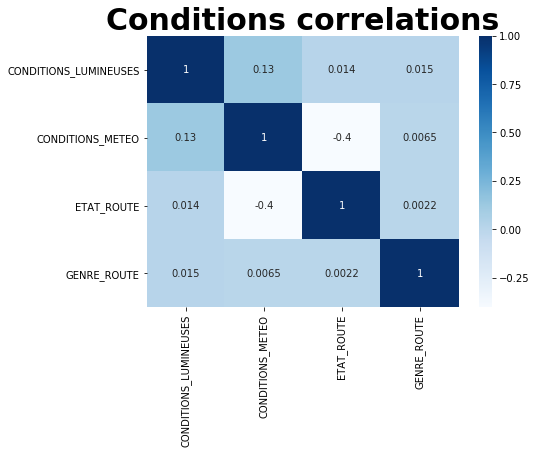

In [56]:
# Search for correlations on conditions features (categorical)
conditions_features = ['CONDITIONS_LUMINEUSES', 'CONDITIONS_METEO', 'ETAT_ROUTE', 'GENRE_ROUTE']
conditions = acc_df[conditions_features]

# Encode features to
from sklearn.preprocessing import LabelEncoder

for feature in conditions_features:
    le = LabelEncoder()
    le = le.fit(conditions[feature])
    conditions[feature] = le.transform(conditions[feature])

# Compute and visualize correlations
fig = plt.figure(figsize=(7,5))
plt.title('Conditions correlations', fontsize=30).set_weight('bold')
ax = sns.heatmap(conditions.corr(), cmap="Blues", annot=True)

From the heatmap above, it can be observed that **light conditions** and **meteo conditions** are slightly correlated when talking about context of accidents.

## 2.4 Accident type
<a id='324Accident'></a>

And important question to answer is **WHY**. The main causes for each accident group/type will be described in this section.

Three main features will be analysed in this section:
- `GROUPE_ACCIDENT`
- `CAUSE`


Let's start analysing the accident group.

### 2.4.1 Accident group

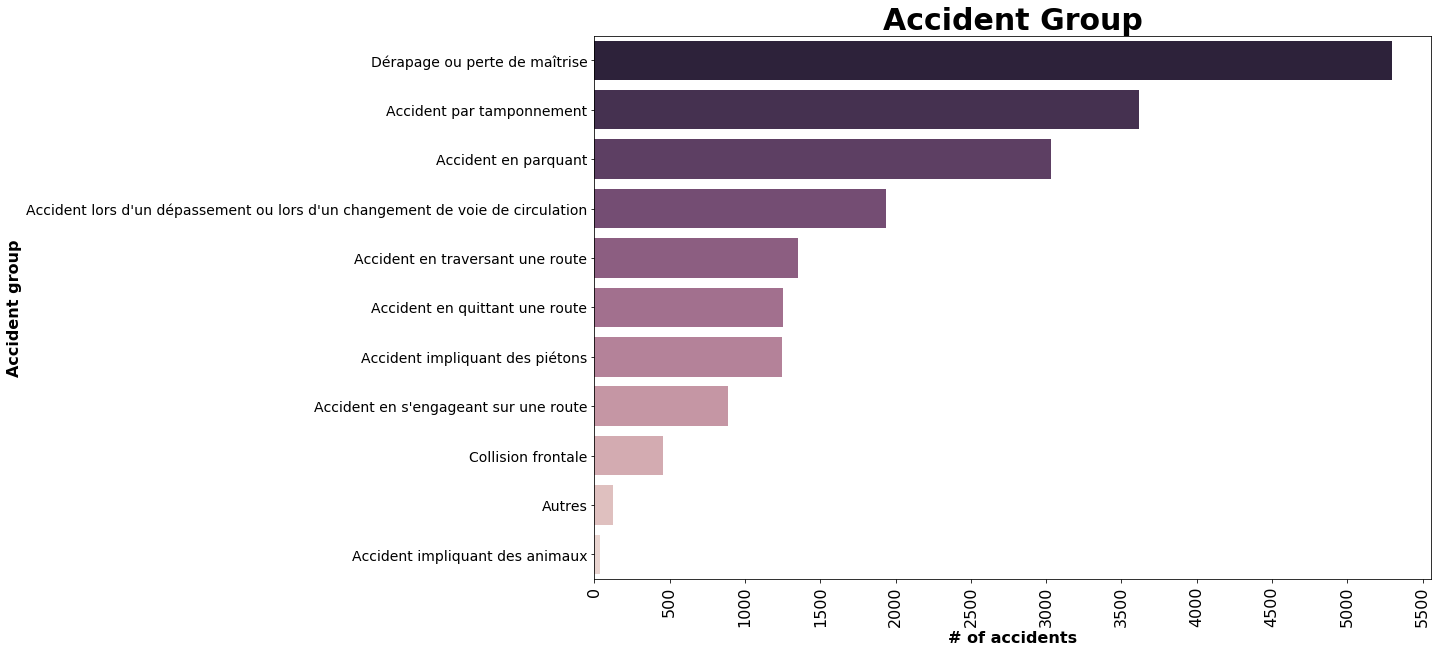

In [20]:
# Visualize the accident group
plt.figure(figsize=(15,10))
groupe_accidents = acc_df.GROUPE_ACCIDENT.value_counts()
ax = sns.barplot(x=groupe_accidents, 
                 y=groupe_accidents.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(groupe_accidents.index)))
ax.set(xticks=np.linspace(0,5500,num=12))
#value_barplot_label(ax)
plt.title("Accident Group", fontsize=30).set_weight('bold')
tick_format(ax, 1)
ax.set_ylabel('Accident group', fontsize=16).set_weight('bold')
ax.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

By the figure above, it can be identified that the accident groups with more accidents are:
- Dérapage ou perte de maîtrise
- Accident par tamponnement
- Accident en parquant


### 2.4.1 Cause
By visualizing and analysing the causes columns,we identified that it is used a '-' in order to separed the group of causes and subgroups. Let's create both features in our dataset:

In [21]:
# Create a new df to treat the causes column
causes = acc_df[['CAUSE', 'GROUPE_ACCIDENT']]
causes['count_'] = causes.CAUSE.apply(lambda x: x.count(' - '))
del causes['GROUPE_ACCIDENT']

# Split the causes into two columns, group and sugroup of causes
conflictive_txt = "(confusion frein - accélérateur, glisser de la pédale de frein dans les véhicules à transmission automatique, etc.)"
causes.CAUSE = causes.CAUSE.str.replace(conflictive_txt, "")
causes['count_'] = causes.CAUSE.apply(lambda x: x.count(' - '))
causes = causes.CAUSE.str.split(' - ', expand=True)
causes.rename(columns ={0: 'CAUSE_g', 1: 'CAUSE_sg'}, inplace=True)
acc_df = pd.concat([acc_df, causes], axis=1)
del acc_df['CAUSE']
acc_df.head(2)

/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,DATE_,GROUPE_ACCIDENT,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,ETAT_ROUTE,GENRE_ROUTE,...,NB_BUS,NB_TRAM,YEAR,MONTH,DAY,HOUR,DayTime,SEASON,CAUSE_g,CAUSE_sg
0,2010-11-30,Dérapage ou perte de maîtrise,Genève,Nuit,Chute de neige,Avec blessés légers,6.153116,46.200401,Enneigée,Route secondaire,...,0.0,0.0,2010,11,30,21,Evening,Autumn,Inattention et distraction,Manque d'attention momentané
1,2010-12-08,Autres,Genève,Jour,Beau,Autres,6.129641,46.206753,Sèche,Route secondaire,...,0.0,0.0,2010,12,8,14,Afternoon,Winter,Utilisation inadéquate du véhicule,Stationnement sans précautions suffisantes


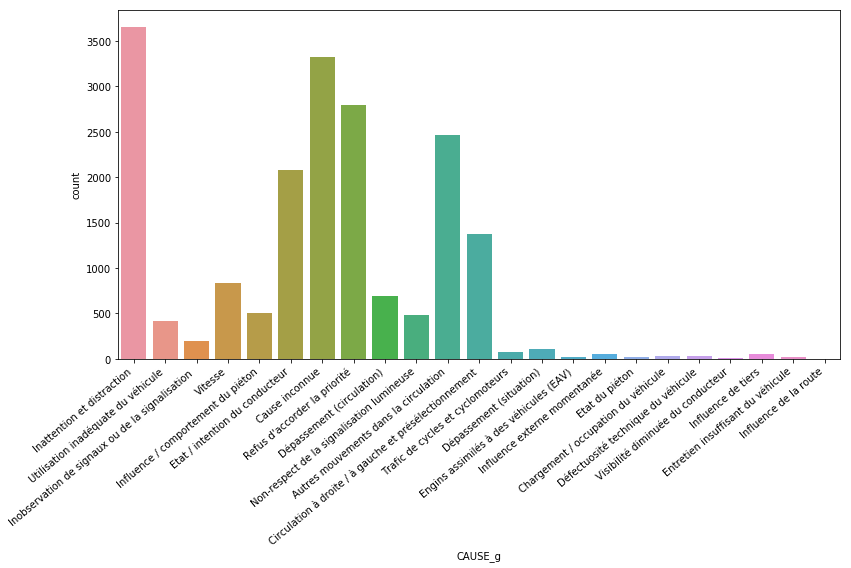

In [22]:
# Visualize main causes
plt.figure(figsize=(12,8))
ax = sns.countplot(acc_df['CAUSE_g'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

`Refuse to give priority` is a major cause. Let's investigate it:

In [24]:
# Create a new dataframe for this cause
nopriority_df = acc_df[acc_df.CAUSE_g == 'Refus d\'accorder la priorité']
nopriority_df.reset_index(drop=True, inplace=True)
nopriority_df.head(2)

,DATE_,GROUPE_ACCIDENT,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,ETAT_ROUTE,GENRE_ROUTE,...,NB_BUS,NB_TRAM,YEAR,MONTH,DAY,HOUR,DayTime,SEASON,CAUSE_g,CAUSE_sg
0,2010-06-26,Accident impliquant des piétons,Petit-Lancy,Jour,Beau,Avec blessés légers,6.128663,46.177943,Sèche,Route principale,...,0.0,0.0,2010,6,26,18,Evening,Spring,Refus d'accorder la priorité,Arrêt obligatoire devant un passage pour piétons
1,2010-08-10,Accident en traversant une route,Genève,Jour,Beau,Avec blessés légers,6.136155,46.220468,Sèche,Route secondaire,...,0.0,0.0,2010,8,10,10,Morning,Summer,Refus d'accorder la priorité,Priorité avec une signalisation fixe 'Cédez le...


Let's plot the **SUBCAUSES** for this important category of accidents:

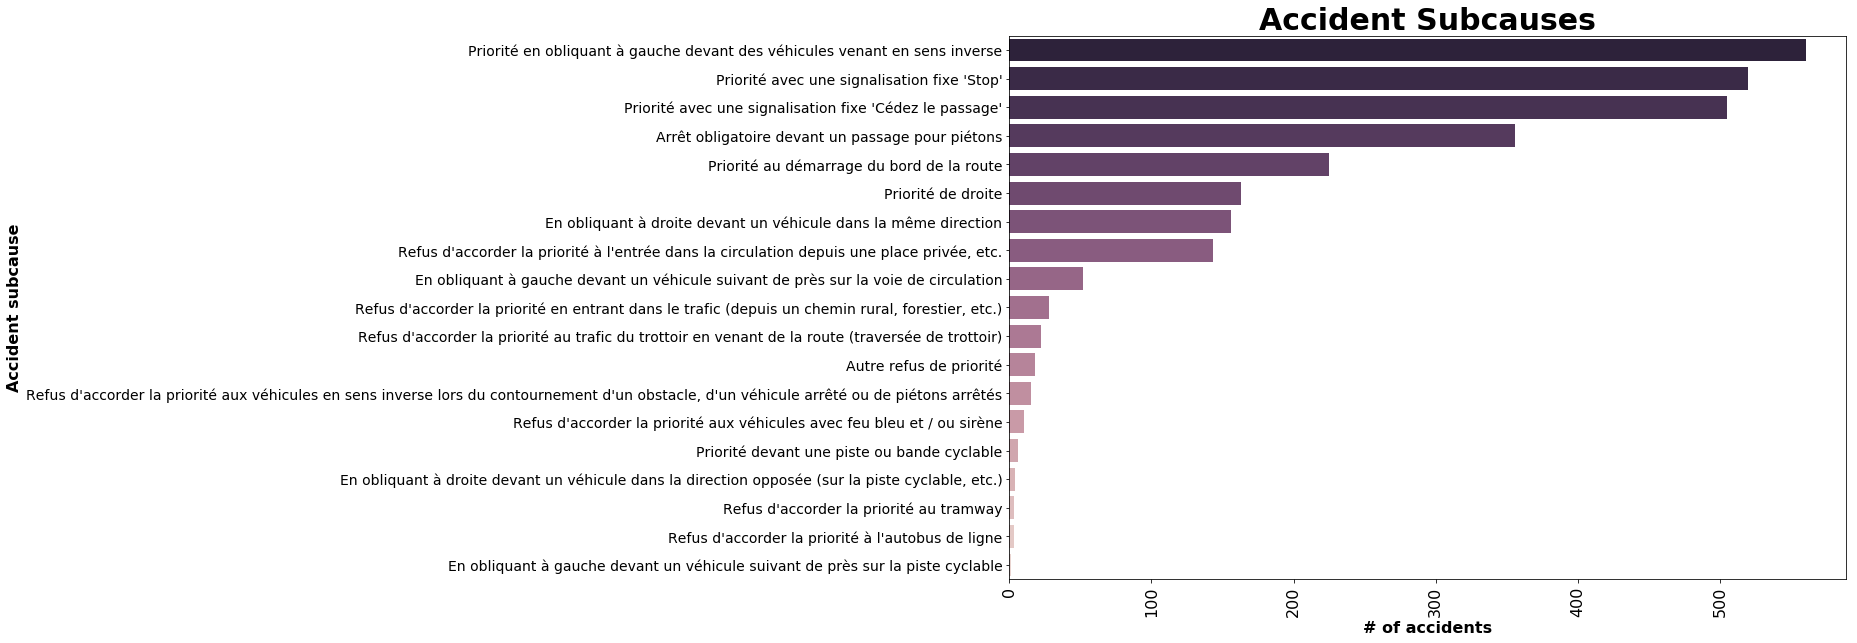

In [25]:
# Visualize the accident group
plt.figure(figsize=(15,10))
subcauses_accidents = nopriority_df['CAUSE_sg'].value_counts()
ax = sns.barplot(x=subcauses_accidents, 
                 y=subcauses_accidents.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(subcauses_accidents.index)))
plt.title("Accident Subcauses", fontsize=30).set_weight('bold')
tick_format(ax, 1)
ax.set_ylabel('Accident subcause', fontsize=16).set_weight('bold')
ax.set_xlabel('# of accidents', fontsize=16).set_weight('bold')


We see that there are a lot of subcauses: let's keep only the "important" ones i.e. the ones that have at least 100 accidents

In [26]:
# Keep subcauses with at least 100 accidents
important_subcauses = list(nopriority_df['CAUSE_sg'].value_counts()[nopriority_df['CAUSE_sg'].value_counts()>100].index)
important_subcauses

['Priorité en obliquant à gauche devant des véhicules venant en sens inverse',
 "Priorité avec une signalisation fixe 'Stop'",
 "Priorité avec une signalisation fixe 'Cédez le passage'",
 'Arrêt obligatoire devant un passage pour piétons',
 'Priorité au démarrage du bord de la route',
 'Priorité de droite',
 'En obliquant à droite devant un véhicule dans la même direction',
 "Refus d'accorder la priorité à l'entrée dans la circulation depuis une place privée, etc."]

Let's keep only the major subcauses on accidents for nopriority_df

In [67]:
nopriority_df = nopriority_df[[row in important_subcauses for row in nopriority_df['CAUSE_sg'] ]].reset_index(drop=True)

A further analysis on the the "**Carrefour_DB_expanalysis.ipynb**"

## 2.5 Accident seriousness

In this section, the seriousness of the accidents will be investigated.

The features related to the accident seriousness are the following:
- `CONSEQUENCES`
- `NB_BLESSES_LEGERS`
- `NB_BLESSES_GRAVES`
- `NB_TUES`
- `NB_ENFANTS_IMPLIQUES`
- `NB_ENFANTS_ECOLE`
- `NB_PIETONS`


In [38]:
# Observe the proportion of each consequence
acc_df.CONSEQUENCES.value_counts()

Autres                 11462
Avec blessés légers     5408
Avec blessés graves     2279
Avec tués                 82
Name: CONSEQUENCES, dtype: int64

It can be observed that less than a half of accidents are with injured or death people. In addition, the death accidents represent 82 out of 19'000 accident during 6 years.

In [39]:
# Observe the distribution of slight injured in an accident
acc_df.NB_BLESSES_LEGERS.value_counts()

0.0    13494
1.0     4943
2.0      630
3.0      115
4.0       28
5.0       15
6.0        6
Name: NB_BLESSES_LEGERS, dtype: int64

In [40]:
# Observe the distribution of grave injured in an accident
acc_df.NB_BLESSES_GRAVES.value_counts()

0.0    16942
1.0     2213
2.0       68
3.0        7
4.0        1
Name: NB_BLESSES_GRAVES, dtype: int64

In [42]:
# Observe the distribution of number of deaths in an accident
acc_df.NB_TUES.value_counts()

0.0    19149
1.0       81
2.0        1
Name: NB_TUES, dtype: int64

In [43]:
# Observe the distribution of children involved
acc_df.NB_ENFANTS_IMPLIQUES.value_counts()

0.0     18637
1.0       491
2.0        83
3.0        16
4.0         3
13.0        1
Name: NB_ENFANTS_IMPLIQUES, dtype: int64

In [44]:
# Observe the distribution of school schildren involved
acc_df.NB_ENFANTS_ECOLE.value_counts()

0.0     19170
1.0        56
2.0         3
11.0        1
3.0         1
Name: NB_ENFANTS_ECOLE, dtype: int64

In [45]:
# Observe the distribution of grave injured
acc_df.NB_PIETONS.value_counts()

0.0    17878
1.0     1286
2.0       57
3.0        9
6.0        1
Name: NB_PIETONS, dtype: int64

In [49]:
# Assemble all the seriouness features in a sole dataframe
seriousness_features = ['CONSEQUENCES', 'NB_BLESSES_LEGERS', 'NB_BLESSES_GRAVES', 'NB_TUES', 
                        'NB_ENFANTS_IMPLIQUES', 'NB_ENFANTS_ECOLE', 'NB_PIETONS']

seriousness = acc_df[seriousness_features]
seriousness.head(2)

,CONSEQUENCES,NB_BLESSES_LEGERS,NB_BLESSES_GRAVES,NB_TUES,NB_ENFANTS_IMPLIQUES,NB_ENFANTS_ECOLE,NB_PIETONS
0,Avec blessés légers,1.0,0.0,0.0,0.0,0.0,1.0
1,Autres,0.0,0.0,0.0,0.0,0.0,0.0


Let's investigate if there exists any correlation between the consequence type and the number of children /school children / pedestrian involved:

/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


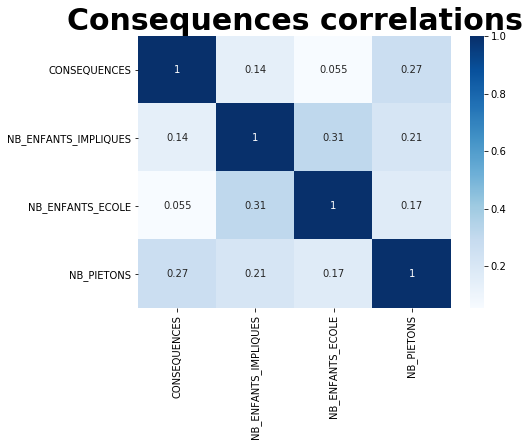

In [55]:
# Compute correltion between the following features
consequences_features = ['CONSEQUENCES','NB_ENFANTS_IMPLIQUES', 'NB_ENFANTS_ECOLE', 'NB_PIETONS']
conseq_corr = seriousness[consequences_features]

# Encode features
for feature in consequences_features:
    le = LabelEncoder()
    le = le.fit(conseq_corr[feature])
    conseq_corr[feature] = le.transform(conseq_corr[feature])

# Compute and visualize correlations
fig = plt.figure(figsize=(7,5))
plt.title('Consequences correlations', fontsize=30).set_weight('bold')
ax = sns.heatmap(conseq_corr.corr(), cmap="Blues", annot=True)

It can be observed that the feature with higher correlation with the kind of consequence is the number of pedetrian involved.

A further analysis could be done to investigate the correlation between the accident group and the seriouness of the accident.

## 2.6 Vehicles involved

In [1]:
# Helper functions
def moto_gp(x):
    return x['NB_CYCLOMOTEURS']+x['NB_MOTOS_50']+x['NB_MOTOS_125']+x['NB_ENFANTS_IMPLIQUES']

def Bike_gp(x):
    return x['NB_BICYCLETTES']+x['NB_VAE_25']+x['NB_VAE_45']

def publictransport_gp(x):
    return x['NB_BUS']+x['NB_TRAM']

def professionaltrip_gp(x):
    return x['NB_VOITURES_LIVRAISON']+x['NB_CAMIONS']+x['NB_BUS']+x['NB_TRAM']

## Save the datafram with new features

In order to summerize all the new features added in this Exploratory analysis, we save this dataframe in our main directory. This datframe will be used in further analysis.

In [ ]:
# Upload
acc_df.to_pickle('acc_df.pkl')
# Download
acc_df = pd.read_pickle('acc_df.pkl')
acc_df

# Prosposals for milestone 3

- Investigate if the months/days when the holidays start or end. To do it, the geneva holiday calendar will be imported.

- Investigate the correlation between the accident group and the seriousness of the accident
